In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/football-match-probability-prediction/sample_submission.csv
/kaggle/input/football-match-probability-prediction/train_target_and_scores.csv
/kaggle/input/football-match-probability-prediction/train.csv
/kaggle/input/football-match-probability-prediction/test.csv


In [2]:
#import modules
from sklearn import metrics, model_selection
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

%matplotlib inline

#loading the data
train = pd.read_csv('/kaggle/input/football-match-probability-prediction/train.csv')
test = pd.read_csv('/kaggle/input/football-match-probability-prediction/test.csv')

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3457: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


Features Construction:
* is_cup converts to 0/1
* matchday converts to time interval
* previous n_game form: goal difference, average points, average goal difference
* coach change

In [3]:
train.is_cup.value_counts()

False    101856
True       9081
Name: is_cup, dtype: int64

In [4]:
a=train.is_cup.apply(lambda x: np.multiply(x, 1))
a

0         0.0
1         0.0
2         0.0
3         0.0
4         0.0
         ... 
110933    0.0
110934    0.0
110935    0.0
110936    0.0
110937    0.0
Name: is_cup, Length: 110938, dtype: float64

In [5]:
a.value_counts()

0.0    101856
1.0      9081
Name: is_cup, dtype: int64

In [6]:
def is_cup_conversion(df):
    '''convert is_cup column from boolean to 0/1'''
    df.is_cup = df.is_cup.apply(lambda x: np.multiply(x, 1) )
    return df

In [7]:
#is_cup_conversion(train)

In [8]:
#%timeit train['home_has_coach_change']=np.array(any([(train.loc[r, 'home_team_coach_id']!=train.loc[r, f'home_team_history_coach_{i}']) & (np.isnan(train.loc[r, f'home_team_history_coach_{i}'])==False) for i in range(1,11) ]) for r in train.index)

#train['home_has_coach_change']=train.apply(lambda r: any([(r['home_team_coach_id']!=r[f'home_team_history_coach_{i}']) 
                                                          & (np.isnan(r[f'home_team_history_coach_{i}'])==False) for i in range(1,11) ]) , axis=1)

In [9]:
#train.home_has_coach_change.value_counts()

In [10]:
#train[train.home_has_coach_change==True]

home_has_coach_change = train.apply(lambda r: any([(r['home_team_coach_id']!=r[f'home_team_history_coach_{i}']) 
                                                          & (np.isnan(r[f'home_team_history_coach_{i}'])==False) for i in range(1,11) ]) , axis=1)
home_has_coach_change = home_has_coach_change.apply(lambda x: np.multiply(x, 1) )

In [11]:
#home_has_coach_change

In [12]:
def has_coach_change(df):
    '''add features indicating whether home and away teams have changed coach'''
    home_has_coach_change = df.apply(lambda r: any([(r['home_team_coach_id']!=r[f'home_team_history_coach_{i}']) 
                                                          & (np.isnan(r[f'home_team_history_coach_{i}'])==False) for i in range(1,11) ]) , axis=1)
    home_has_coach_change = home_has_coach_change.apply(lambda x: np.multiply(x, 1) )
    away_has_coach_change = df.apply(lambda r: any([(r['away_team_coach_id']!=r[f'away_team_history_coach_{i}']) 
                                                          & (np.isnan(r[f'away_team_history_coach_{i}'])==False) for i in range(1,11) ]) , axis=1)
    away_has_coach_change = away_has_coach_change.apply(lambda x: np.multiply(x, 1) )
    new_columns = {'home_has_coach_change': home_has_coach_change, 'away_has_coach_change': away_has_coach_change}
    df = pd.concat([df, pd.DataFrame(new_columns)], axis=1)
    return df

In [13]:
#has_coach_change(train)

In [14]:
#%timeit train['home_team_history_match_interval_1'] = np.array((pd.Timestamp(train.loc[r, 'match_date'])-pd.Timestamp(train.loc[r, f'home_team_history_match_date_1']))/np.timedelta64(1, "D") for r in train.index)

for i in range(1,11):
    train[f'home_team_history_match_interval_{i}'] = train.apply( lambda r:
            (pd.Timestamp(r['match_date'])-pd.Timestamp(r[f'home_team_history_match_date_{i}']))
            /np.timedelta64(1, "D") 
            ,axis=1)

In [15]:
def add_match_interval(df):
    '''add features indicating the time gap between the match day of each previous match for the home and away teams,
    as an reflection of fatique factor'''
    for i in range(1,11):
        df[f'home_team_history_match_interval_{i}'] = train.apply( lambda r:
            (pd.Timestamp(r['match_date'])-pd.Timestamp(r[f'home_team_history_match_date_{i}']))
            /np.timedelta64(1, "D") 
            ,axis=1).astype('float32')
        df[f'away_team_history_match_interval_{i}'] = train.apply( lambda r:
            (pd.Timestamp(r['match_date'])-pd.Timestamp(r[f'away_team_history_match_date_{i}']))
            /np.timedelta64(1, "D") 
            ,axis=1).astype('float32')
    return df

In [16]:
#add_match_interval(train)

In [17]:
def result_point(goal_difference):
    if goal_difference > 0:
        return 3
    elif goal_difference==0:
        return 1
    else:
        return 0

In [18]:
def add_form_features(df):
    '''adding form features for home and away teams, including rating difference and goal difference for each previous match,
    and the average points got, average goal scored, average goal conceded and average goal difference up to that match as previous n-match form'''
    for i in range(1,11):
        df[f'home_team_history_goal_difference_{i}']=df[f'home_team_history_goal_{i}']-df[f'home_team_history_opponent_goal_{i}']
        df[f'away_team_history_goal_difference_{i}']=df[f'away_team_history_goal_{i}']-df[f'away_team_history_opponent_goal_{i}']
        df[f'home_team_history_rating_difference_{i}']=df[f'home_team_history_rating_{i}']-df[f'home_team_history_opponent_rating_{i}']
        df[f'away_team_history_rating_difference_{i}']=df[f'away_team_history_rating_{i}']-df[f'away_team_history_opponent_rating_{i}']
        df[f'home_team_history_average_goal_scored_{i}']=df.apply(lambda r: pd.Series(r[f'home_team_history_goal_{j}'] for j in range (1,i+1)).mean(), axis=1)
        df[f'away_team_history_average_goal_scored_{i}']=df.apply(lambda r: pd.Series(r[f'away_team_history_goal_{j}'] for j in range (1,i+1)).mean(), axis=1)
        df[f'home_team_history_average_goal_conceded_{i}']=df.apply(lambda r: pd.Series(r[f'home_team_history_opponent_goal_{j}'] for j in range (1,i+1)).mean(), axis=1)
        df[f'away_team_history_average_goal_conceded_{i}']=df.apply(lambda r: pd.Series(r[f'away_team_history_opponent_goal_{j}'] for j in range (1,i+1)).mean(), axis=1)
        df[f'home_team_history_average_goal_difference_{i}']=df[f'home_team_history_average_goal_scored_{i}']-df[f'home_team_history_average_goal_conceded_{i}']
        df[f'away_team_history_average_goal_difference_{i}']=df[f'away_team_history_average_goal_scored_{i}']-df[f'away_team_history_average_goal_conceded_{i}']
        df[f'home_team_history_average_point_{i}']=df.apply(lambda r: pd.Series(r[f'home_team_history_goal_difference_{j}'] for j in range (1,i+1)).apply(result_point).mean(), axis=1)
        df[f'away_team_history_average_point_{i}']=df.apply(lambda r: pd.Series(r[f'away_team_history_goal_difference_{j}'] for j in range (1,i+1)).apply(result_point).mean(), axis=1)    
    return df

In [19]:
def preprocession(df):
    df=is_cup_conversion(df)
    df=has_coach_change(df)
    df=add_match_interval(df)
    df=add_form_features(df)
    return df

In [20]:
train_p=preprocession(train)

In [21]:
train_p

,id,target,home_team_name,away_team_name,match_date,league_name,league_id,is_cup,home_team_coach_id,away_team_coach_id,...,home_team_history_rating_difference_10,away_team_history_rating_difference_10,home_team_history_average_goal_scored_10,away_team_history_average_goal_scored_10,home_team_history_average_goal_conceded_10,away_team_history_average_goal_conceded_10,home_team_history_average_goal_difference_10,away_team_history_average_goal_difference_10,home_team_history_average_point_10,away_team_history_average_point_10
0,11906497,away,Newell's Old Boys,River Plate,2019-12-01 00:45:00,Superliga,636,0.0,468196.0,468200.0,...,3.651948,1.239743,1.3,1.6,1.0,0.9,0.3,0.7,1.5,1.9
1,11984383,home,Real Estelí,Deportivo Las Sabanas,2019-12-01 01:00:00,Primera Division,752,0.0,516788.0,22169161.0,...,3.916450,-5.890736,0.9,0.8,1.0,1.4,-0.1,-0.6,1.0,1.1
2,11983301,draw,UPNFM,Marathón,2019-12-01 01:00:00,Liga Nacional,734,0.0,2510608.0,456313.0,...,1.532352,6.159063,1.9,2.1,1.7,1.1,0.2,1.0,1.5,2.1
3,11983471,away,León,Morelia,2019-12-01 01:00:00,Liga MX,743,0.0,1552508.0,465797.0,...,3.508762,-2.332587,1.8,2.4,1.3,2.0,0.5,0.4,1.6,1.5
4,11883005,home,Cobán Imperial,Iztapa,2019-12-01 01:00:00,Liga Nacional,705,0.0,429958.0,426870.0,...,6.050450,-2.741227,1.8,1.8,1.4,1.0,0.4,0.8,1.8,1.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110933,18030016,draw,Zamora Fútbol Club,Hermanos Colmenares,2021-04-30 23:00:00,Primera Division,800,0.0,7708122.0,37564088.0,...,0.972825,4.648450,1.7,1.7,0.9,1.4,0.8,0.3,1.7,1.7
110934,18030096,away,Royal Pari,Oriente Petrolero,2021-04-30 23:00:00,Liga De Futbol Prof,1098,0.0,465833.0,16488543.0,...,10.097321,-1.669872,2.6,1.3,1.4,1.7,1.2,-0.4,1.7,1.1
110935,17715497,draw,São Bernardo,Água Santa,2021-04-30 23:00:00,Paulista A2,1314,0.0,8416491.0,528562.0,...,0.782550,-0.990867,1.0,1.2,1.1,0.2,-0.1,1.0,1.2,2.3
110936,17944153,away,Everton,La Serena,2021-05-01 00:00:00,Primera Division,663,0.0,6973085.0,471757.0,...,2.833663,-2.219119,1.0,0.7,1.4,0.7,-0.4,0.0,1.3,1.1


In [22]:
for i in train_p.columns:
    print(i, train_p.loc[467,i])

id 11978898
target home
home_team_name Akwa Starlets
away_team_name Warri Wolves
match_date 2019-12-01 15:00:00
league_name Npfl
league_id 1475
is_cup 0.0
home_team_coach_id 37252510.0
away_team_coach_id 37252510.0
home_team_history_match_date_1 2019-11-24 15:00:00
home_team_history_match_date_2 2019-11-21 15:00:00
home_team_history_match_date_3 2019-11-17 15:00:00
home_team_history_match_date_4 nan
home_team_history_match_date_5 nan
home_team_history_match_date_6 nan
home_team_history_match_date_7 nan
home_team_history_match_date_8 nan
home_team_history_match_date_9 nan
home_team_history_match_date_10 nan
home_team_history_is_play_home_1 0.0
home_team_history_is_play_home_2 1.0
home_team_history_is_play_home_3 0.0
home_team_history_is_play_home_4 nan
home_team_history_is_play_home_5 nan
home_team_history_is_play_home_6 nan
home_team_history_is_play_home_7 nan
home_team_history_is_play_home_8 nan
home_team_history_is_play_home_9 nan
home_team_history_is_play_home_10 nan
home_team_histo

In [23]:
match_date_columns=[col for col in train_p.columns if ('match_date' in col)]
match_date_columns

['match_date',
 'home_team_history_match_date_1',
 'home_team_history_match_date_2',
 'home_team_history_match_date_3',
 'home_team_history_match_date_4',
 'home_team_history_match_date_5',
 'home_team_history_match_date_6',
 'home_team_history_match_date_7',
 'home_team_history_match_date_8',
 'home_team_history_match_date_9',
 'home_team_history_match_date_10',
 'away_team_history_match_date_1',
 'away_team_history_match_date_2',
 'away_team_history_match_date_3',
 'away_team_history_match_date_4',
 'away_team_history_match_date_5',
 'away_team_history_match_date_6',
 'away_team_history_match_date_7',
 'away_team_history_match_date_8',
 'away_team_history_match_date_9',
 'away_team_history_match_date_10']

In [24]:
X=train_p.drop(match_date_columns, axis=1)
X=X.drop(['id','home_team_name','away_team_name','league_name','target'], axis=1)
y=train_p['target']

In [25]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
label_encoder = label_encoder.fit(y)
label_encoded_y = label_encoder.transform(y)

In [26]:
from sklearn import model_selection
X_train, X_valid, y_train, y_valid = model_selection.train_test_split(X, label_encoded_y, train_size=0.8, random_state=42)

In [27]:
y_train

array([2, 2, 0, ..., 1, 0, 0])

In [28]:
pd.Series(y_train).value_counts()

2    38545
0    28086
1    22119
dtype: int64

In [29]:
import xgboost as xgb
d_train = xgb.DMatrix(X_train, y_train)
d_test = xgb.DMatrix(X_valid, y_valid)

In [30]:
params_1 = {
    'booster': 'gbtree',
    'max_depth': 5, 
    'learning_rate': 0.05,
    'subsample': 0.5,
    'sample_type': 'uniform',
    'normalize_type': 'tree',
    'objective': 'multi:softprob',
    'num_class': 3,
    'rate_drop': 0.1,
    'eval_metric':'mlogloss'
    }

num_round = 300
evallist = [(d_test, 'eval'), (d_train, 'train')]

In [31]:
bst = xgb.train(params_1, d_train, num_round, evallist, early_stopping_rounds=5)

[20:54:53] WARNING: ../src/learner.cc:576: 
Parameters: { "normalize_type", "rate_drop", "sample_type" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	eval-mlogloss:1.09351	train-mlogloss:1.09307
[1]	eval-mlogloss:1.08866	train-mlogloss:1.08785
[2]	eval-mlogloss:1.08422	train-mlogloss:1.08296
[3]	eval-mlogloss:1.08013	train-mlogloss:1.07839
[4]	eval-mlogloss:1.07639	train-mlogloss:1.07425
[5]	eval-mlogloss:1.07288	train-mlogloss:1.07037
[6]	eval-mlogloss:1.06948	train-mlogloss:1.06658
[7]	eval-mlogloss:1.06647	train-mlogloss:1.06311
[8]	eval-mlogloss:1.06359	train-mlogloss:1.05976
[9]	eval-mlogloss:1.06085	train-mlogloss:1.05669
[10]	eval-mlogloss:1.05833	train-mlogloss:1.05375
[11]	eval-mlogloss:1.05599	train-mlogloss:1.05102
[12]	eval-mloglos

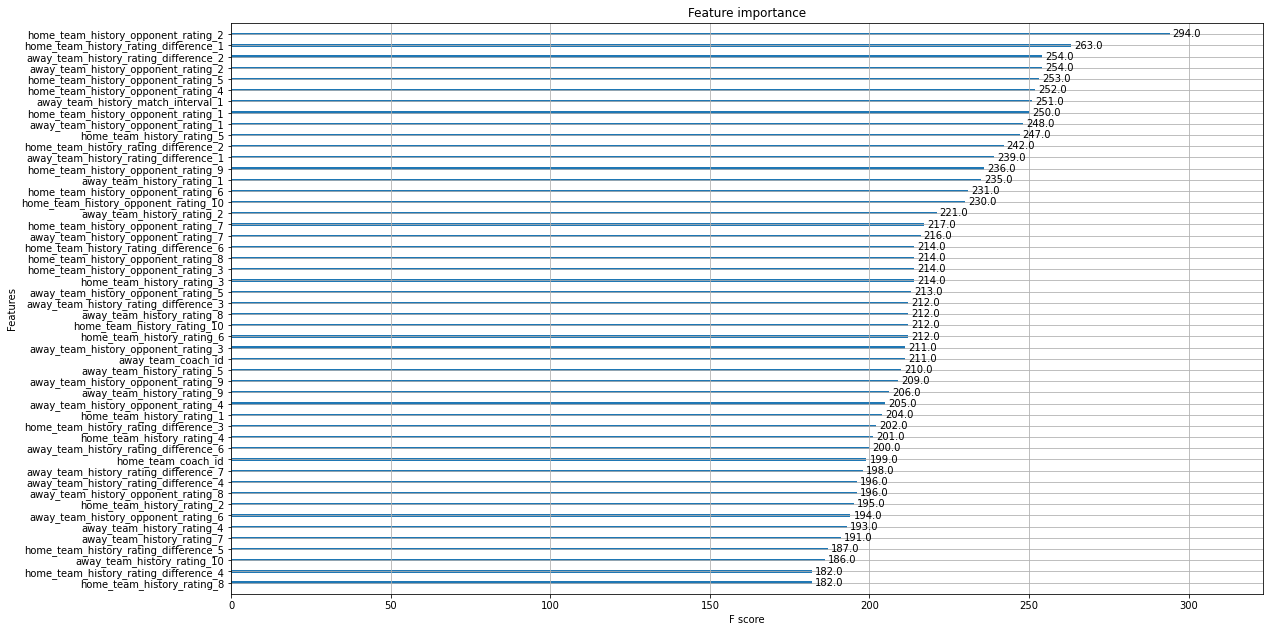

In [32]:
xgb.plot_importance(bst, max_num_features=50)
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

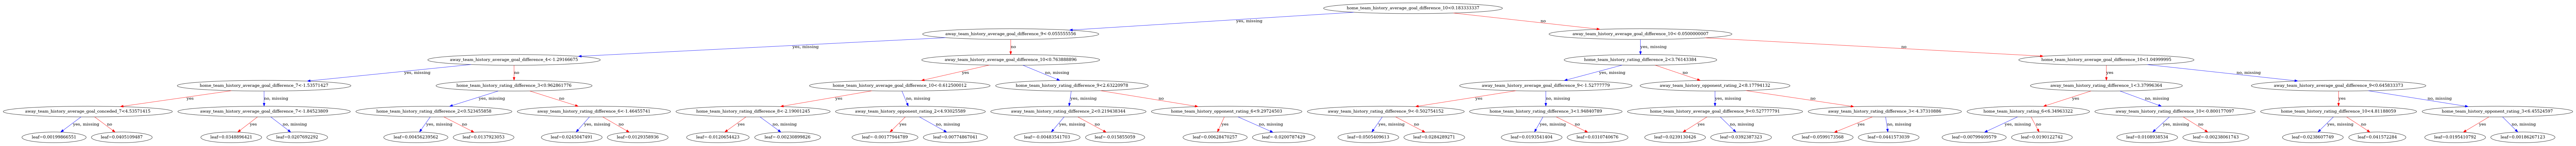

In [33]:
xgb.plot_tree(bst, num_trees=2)
fig = plt.gcf()
fig.set_size_inches(160, 100)

In [34]:
#from xgboost import XGBClassifier
#clf=XGBClassifier(objective='multi:softprob', early_stopping_rounds=10, eval_metric='mlogloss', evalset = [(X_train, y_train), (X_valid,y_valid)], verbose=True, use_label_encoder=False )

In [35]:
#clf.fit(X_train, y_train)

In [36]:
#xgb.plot_importance(clf)

In [37]:
test_p=preprocession(test)

In [38]:
X_test=test_p.drop(match_date_columns, axis=1)
X_test=X_test.drop(['id','home_team_name','away_team_name','league_name'], axis=1)

In [39]:
X_test_d = xgb.DMatrix(X_test)

In [40]:
predictions = bst.predict(X_test_d, iteration_range=(0, bst.best_iteration))

In [41]:
predictions

array([[0.28254247, 0.30612117, 0.41133642],
       [0.35474092, 0.3135338 , 0.33172524],
       [0.31324726, 0.32723802, 0.35951474],
       ...,
       [0.54855007, 0.26596558, 0.18548436],
       [0.21167079, 0.28670537, 0.5016238 ],
       [0.34921205, 0.31509006, 0.3356979 ]], dtype=float32)

In [42]:
submission = pd.DataFrame(predictions ,columns=label_encoder.inverse_transform([0,1,2]))

In [43]:
submission['id'] = test['id']
display(submission)

,away,draw,home,id
0,0.282542,0.306121,0.411336,17761448
1,0.354741,0.313534,0.331725,17695487
2,0.313247,0.327238,0.359515,17715496
3,0.541183,0.279819,0.178999,17715493
4,0.232026,0.305365,0.462609,17715492
...,...,...,...,...
72706,0.321000,0.294292,0.384708,18450246
72707,0.158425,0.311206,0.530368,18164889
72708,0.548550,0.265966,0.185484,18449018
72709,0.211671,0.286705,0.501624,17958831


In [44]:
submission.to_csv('submission.csv', index=False)

Things to do:
* improve efficiency of pandas manulpuation
* xgboost tuning
* validation set
* model for rating